# Illustrating multilevel and marginal regression with data from a longitudinal autism study

This analysis is based on data from a longitudinal study of children with autism<sup>1</sup>. We will consider how various factors interact with the socialization of a child with autism as they progress through the early stages of their life.

The variables that we focus on here are:

* AGE is the age of a child which, for this dataset, is between two and thirteen years 
* VSAE measures a child's socialization 
* SICDEGP is the expressive language group at age two and can take on values ranging from one to three. Higher values indicate more expressive language.
* CHILDID is the unique ID that is given to each child and acts as their identifier within the dataset

We will first be fitting a multilevel model with explicit random effects of the children to account for the fact that we have repeated measurements on each child, which introduces correlation in our observations.

<sup>1</sup> Anderson, D., Oti, R., Lord, C., and Welch, K. (2009). Patterns of growth in adaptive social abilities among children with autism spectrum disorders. Journal of Abnormal Child Psychology, 37(7), 1019-1034.

### Importing packages and reading data

Before we begin, we need to import a few packages:

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns

Next we read the data and drop cases with missing values.

In [2]:
# Read in the Autism Data
dat = pd.read_csv("autism.csv")

# Drop NA's from the data
dat = dat.dropna()

The first few rows of data appear as follows:

In [3]:
dat.head()

,age,vsae,sicdegp,childid
0,2,6.0,3,1
1,3,7.0,3,1
2,5,18.0,3,1
3,9,25.0,3,1
4,13,27.0,3,1


The level of socialization (`vsae`) tends to increase with `age`.  We can see this through a scatterplot, but since `age` takes on only a few distinct values, we will also visualize the relationship using a series of boxplots.

<Axes: xlabel='age', ylabel='vsae'>

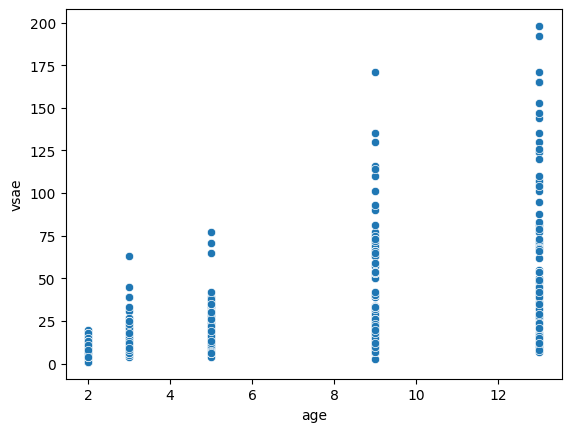

In [4]:
sns.scatterplot(x="age", y="vsae", data=dat)

<Axes: xlabel='age', ylabel='vsae'>

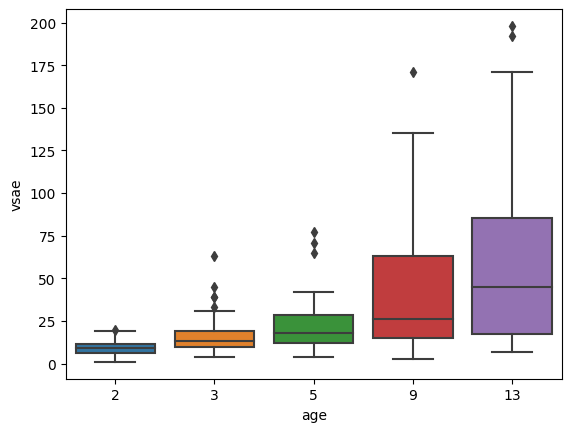

In [5]:
sns.boxplot(x="age", y="vsae", data=dat)

### Multilevel linear regression models

We begin by fitting a basic multilevel linear model, with `vsae` as the response variable, and `age` and `sicdegp` as predictors.  Since `sicdegp` is a categorical variable that has been coded numerically, we use the `C()` syntax in the formula to force it to be treated as categorical.  This is a repeated measures longitudinal dataset, so we treat each child as a group.  In this basic model we include only a random intercept to capture the within-child dependence.

In [6]:
# Specify a model
mlm_mod = sm.MixedLM.from_formula(
    formula = 'vsae ~ age + C(sicdegp)', 
    groups = 'childid',  
    data=dat
)

# Fit the model
mlm_result = mlm_mod.fit(reml=False)

# Print out the summary of the fit
mlm_result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  vsae      
No. Observations:   610      Method:              ML        
No. Groups:         158      Scale:               403.4235  
Min. group size:    1        Log-Likelihood:      -2762.4838
Max. group size:    5        Converged:           Yes       
Mean group size:    3.9                                     
------------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
------------------------------------------------------------
Intercept        -7.169    2.531 -2.832 0.005 -12.129 -2.208
C(sicdegp)[T.2]   5.267    2.970  1.773 0.076  -0.554 11.088
C(sicdegp)[T.3]  21.402    3.326  6.435 0.000  14.883 27.921
age               4.478    0.211 21.273 0.000   4.066  4.891
childid Var     142.014    1.612                            
============================================================

"""

We begin by inspecting the mean structure of the model.  The coefficient for `age` is approximately 4.5, and is statistically different from zero.  Thus, for a fixed level of `sicdegp` (the only other explanatory variable), the expected value of `vsae` increases by approximately 4.5 units with each additional year of age.  Statsmodels has chosen `sicdegp=1` as the reference level, and included indicator variables for `sicdegp=2` and `sicdegp=3`.  The coefficient for `sicdegp=2` is not statistically different from zero, so there is no evidence that the mean value of `vsae` differs between `sicdegp=1` and `sicdegp=2`, when `age` is fixed.  However the estimate for `sicdegp=3` is strongly statistically different from zero, with a point estimate of approximately 21.4.  Thus, children with `sicdegp=3` have approximately 21.4 points greater `vsae` than children with `sicegp=1` or `sicdegp=2`, for a fixed age.   

The point estimate of the variance for the child random intercepts is 146.7, which corresponds to a standard deviation of 12.1.  Thus, a randomly selected child will be consistently different from the average child across all time points, with a stable difference $\gamma_i$ (for child $i$), that has standard deviation 12.1.  Note that the $\gamma_i$ have mean zero, so some children are consistently greater than the mean child, and other children are consistently less than the mean child.

The "random intercepts" model above takes the differences between children to be stable over time.  That is, each child is shifted from the mean child by a random intercept ($\gamma_i$) that shifts `vsae` at all ages equally.  Another possibility is that children also differ by the rate of change, or slope of `vsae` with respect to `age`.  To capture this possibility, we include a random slope for age.  When modeling random slopes for quantitative variables in a multilevel model, it is common to center the covariate as we have done below.

In [7]:
dat["age_cen"] = dat["age"] - dat["age"].mean()

# Specify a model
mlm_mod2 = sm.MixedLM.from_formula(
    formula = 'vsae ~ age + C(sicdegp)', 
    groups = 'childid', 
    re_formula="1",
    vc_formula={"age_cen": "0+age_cen"},
    data=dat
)

# Fit the model
mlm_result2 = mlm_mod2.fit(reml=False)

# Print out the summary of the fit
mlm_result2.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  vsae      
No. Observations:   610      Method:              ML        
No. Groups:         158      Scale:               72.5747   
Min. group size:    1        Log-Likelihood:      -2550.9869
Max. group size:    5        Converged:           Yes       
Mean group size:    3.9                                     
------------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
------------------------------------------------------------
Intercept        -6.586    2.914 -2.260 0.024 -12.297 -0.875
C(sicdegp)[T.2]   4.129    2.845  1.452 0.147  -1.446  9.705
C(sicdegp)[T.3]  20.828    3.178  6.553 0.000  14.598 27.057
age               4.471    0.358 12.493 0.000   3.770  5.173
childid Var     196.873    3.612                            
age_cen Var      17.255    0.309                            
============================================================

"""

The mean structure of the model above can be interpreted similarly to the mean structure of the random intercepts model.  The variance structure now describes the unique child effect in terms of both a random intercept and a random age slope.

We may wonder which of these two models better fits the data.  This can be assessed by comparing the models in terms of AIC (the Akaike Information Criterion).  A lower AIC corresponds to a better fit.  The model with random slopes has a substantially better fit to the data, based on the AIC.

In [8]:
print(mlm_result.aic)
print(mlm_result2.aic)

5536.967551282193
5115.973739664486


# Marginal Models

Another powerful approach for analyzing repeated measures data (e.g. longitudinal data as we have here) is marginal regression, which is usually accomplished using a technique known as *generalized estimating equations* (GEE).

The focus of GEE is on the mean structure, but we fit this mean structure in a way that acknowledges the non-independence of the data (i.e. that the repeated observations on one child will be dependent).  In an analysis using GEE, we specify a *working correlation structure*.  This represents an attempt to specify how the observations within a group are correlated, but notably does not need to be correct.  If we mis-specify the working correlation structure, the results of the analysis are still valid.  Below we fit a GEE to the autism data using two working correlation structure, one which specifies the observations on the same child to be independent, and the other specifying that any two observations on the same child have the same correlation between them (known as the "exchangeable" correlation).

In [9]:
model_indep = sm.GEE.from_formula(
    "vsae ~ age + C(sicdegp)",
    groups="childid",
    cov_struct = sm.cov_struct.Independence(), 
    data=dat
    ).fit()
model_indep.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                        vsae   No. Observations:                  610
Model:                                 GEE   No. clusters:                      158
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   5
Family:                           Gaussian   Mean cluster size:                 3.9
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Tue, 18 Feb 2025   Scale:                         549.020
Covariance type:                    robust   Time:                         00:44:34
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -7.9191      2.257     -3.509      0.000     -12.343      -3.496
C(sicdegp)[T.2]     5.8745      2.763      2.126      0.033       0.459      11.290
C(sicdegp)[T.3]    22.1992      3.326      6.675      0.000      15.681      28.717
age                 4.4829      0.402     11.145      0.000       3.695       5.271
==============================================================================
Skew:                          1.9781   Kurtosis:                       7.7095
Centered skew:                 0.8043   Centered kurtosis:              3.7977
==============================================================================
"""

In [10]:
model_exch = sm.GEE.from_formula(
    formula = "vsae ~ age + C(sicdegp)",
    groups="childid",
    cov_struct=sm.cov_struct.Exchangeable(), 
    data=dat
    ).fit()
model_exch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                        vsae   No. Observations:                  610
Model:                                 GEE   No. clusters:                      158
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   5
Family:                           Gaussian   Mean cluster size:                 3.9
Dependence structure:         Exchangeable   Num. iterations:                     6
Date:                     Tue, 18 Feb 2025   Scale:                         549.192
Covariance type:                    robust   Time:                         00:44:34
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -7.1684      2.228     -3.218      0.001     -11.535      -2.802
C(sicdegp)[T.2]     5.2669      2.761      1.907      0.056      -0.145      10.679
C(sicdegp)[T.3]    21.4021      3.342      6.404      0.000      14.852      27.952
age                 4.4783      0.393     11.382      0.000       3.707       5.249
==============================================================================
Skew:                          1.9891   Kurtosis:                       7.7682
Centered skew:                 0.8060   Centered kurtosis:              3.8066
==============================================================================
"""